In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

c:\Users\akars\AppData\Local\Programs\Python\Python310\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.11) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
train_dir = "../data/expressions/train" 
test_dir = "../data/expressions/test"   

In [3]:
img_size = 48 

In [4]:
# Enhanced data augmentation with more techniques
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    rescale=1./255,
    zoom_range=0.15,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [ ]:
# Calculate class weights for handling imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class indices from train_generator
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Create class weights based on actual class distribution
# Using the class counts we found earlier
class_counts = {
    'angry': 3995,
    'disgust': 436, 
    'fear': 4097,
    'happy': 7215,
    'neutral': 4965,
    'sad': 4830,
    'surprise': 3171
}

# Create y array for compute_class_weight
y_array = []
for class_name, count in class_counts.items():
    y_array.extend([class_indices[class_name]] * count)

y_array = np.array(y_array)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_array),
    y=y_array
)

# Create proper dictionary with integer keys
class_weights_dict = {i: float(weight) for i, weight in enumerate(class_weights)}

print("Class weights for balancing:")
for i, class_name in enumerate(class_names):
    weight = class_weights_dict[i]
    print(f"  {class_name}: {weight:.4f}")

print(f"\nClass weights dictionary: {class_weights_dict}")

Class weights for balancing: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}


In [7]:
# Enhanced model architecture with transfer learning
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load pre-trained EfficientNetB0 (adapted for grayscale)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(48, 48, 3)
)

# Freeze base model layers initially
base_model.trainable = False

# Build custom model on top
model = tf.keras.models.Sequential([
    # Convert grayscale to 3 channels for EfficientNet
    tf.keras.layers.Conv2D(3, (1, 1), padding='same', input_shape=(48, 48, 1)),
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compile with improved optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Enhanced training parameters and callbacks
epochs = 30
batch_size = 64

# Callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        '../model/best_expression_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [9]:
# Train with class weights and callbacks
history = model.fit(
    x=train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 2.1600 - accuracy: 0.1832
Epoch 1: val_accuracy improved from -inf to 0.24721, saving model to ../model\best_expression_model.keras


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [ ]:
# Save the improved model in modern Keras format
model.save('../model/improved_expression_model.keras')
print("Model saved successfully!")

In [ ]:
# Fine-tuning: Unfreeze some layers of the base model
base_model.trainable = True

# Unfreeze the last 20 layers of the base model
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Re-compile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
fine_tune_epochs = 15
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    x=train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# Fine-tuning: Unfreeze some layers of the base model
base_model.trainable = True

# Unfreeze the last 20 layers of the base model
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Re-compile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
fine_tune_epochs = 15
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    x=train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

(48, 48)


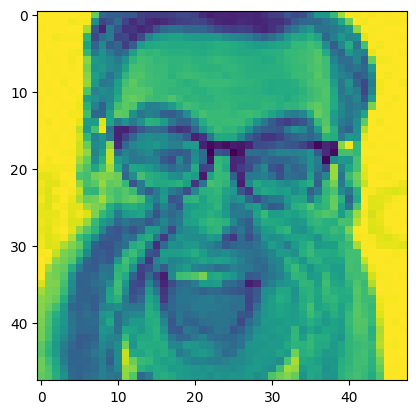

In [ ]:
# Comprehensive evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on training and validation sets
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
test_loss, test_acc = model.evaluate(validation_generator, verbose=0)

print(f"Final train accuracy: {train_acc*100:.2f}%")
print(f"Final validation accuracy: {test_acc*100:.2f}%")

# Generate predictions for detailed analysis
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Classification report
class_labels = list(validation_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Enhanced visualization of training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Combine training histories
total_accuracy = history.history['accuracy'] + history_fine.history['accuracy']
total_val_accuracy = history.history['val_accuracy'] + history_fine.history['val_accuracy']
total_loss = history.history['loss'] + history_fine.history['loss']
total_val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Plot accuracy
ax1.plot(total_accuracy, label='Training Accuracy', linewidth=2)
ax1.plot(total_val_accuracy, label='Validation Accuracy', linewidth=2)
ax1.axvline(x=len(history.history['accuracy'])-1, color='r', linestyle='--', 
            label='Fine-tuning Start', alpha=0.7)
ax1.set_title('Model Accuracy', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(total_loss, label='Training Loss', linewidth=2)
ax2.plot(total_val_loss, label='Validation Loss', linewidth=2)
ax2.axvline(x=len(history.history['loss'])-1, color='r', linestyle='--', 
            label='Fine-tuning Start', alpha=0.7)
ax2.set_title('Model Loss', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print improvement summary
print(f"Improvement Summary:")
print(f"Initial training accuracy: {history.history['accuracy'][-1]*100:.2f}%")
print(f"Final accuracy after fine-tuning: {total_accuracy[-1]*100:.2f}%")
print(f"Initial validation accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"Final validation accuracy: {total_val_accuracy[-1]*100:.2f}%")

In [ ]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 [==============================] - 1s 792ms/step
[0.9426418, 0.0, 0.057358243, 0.0, 0.0, 0.0, 1.1375625e-32]


In [ ]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Angry


In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 7s 295ms/step - loss: 1.9234 - accuracy: 0.5433
final train accuracy = 51.90 , validation accuracy = 54.33


In [ ]:
model.save_weights('../model/expression_model_weights.h5')